In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
# Declaring base
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement

Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Get column info using inspector
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [10]:
# Find the most recent date in the data set.
mostRecentDate = session.execute("SELECT MAX(date) FROM measurement;")

for date in mostRecentDate:
    print(f"most recent date in dataset: {date}")

most recent date in dataset: ('2017-08-23',)


In [11]:
# date 1 year ago from 2017-08-23
Months_Previous_12 = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print(Months_Previous_12)

2016-08-23


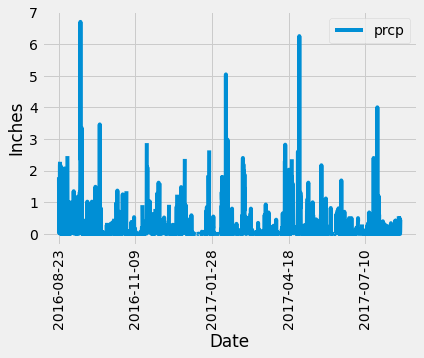

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Perform a query to retrieve the data and precipitation scores
dataPrecipitationScores = session.execute("SELECT * FROM measurement\
                                          WHERE date between '2016-08-23' AND '2017-08-23'; ")

# engine.execute("SELECT * FROM measurement\
#                  WHERE date between '2016-08-23' AND '2017-08-23';").fetchall()

# Save the query results as a Pandas DataFrame and set the index to the date column
dataPrecipitationScoresDF = pd.DataFrame(dataPrecipitationScores).set_index('date')

# Sort the dataframe by date
dataPrecipitationScoresDF = dataPrecipitationScoresDF.sort_values(by='date',ascending=True)

# Use Pandas Plotting with Matplotlib to plot the data
dataPrecipitationScoresDF.plot(y='prcp')
plt.xticks(rotation='vertical')
plt.xlabel('Date')
plt.ylabel('Inches')
plt.show()

In [13]:
# Use Pandas to calculate the summary statistics for the precipitation data
dataPrecipitationScoresDF.describe()['prcp']

count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: prcp, dtype: float64

# Exploratory Station Analysis

In [14]:
# Get column info using inspector
inspector = inspect(engine)
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [15]:
# Design a query to calculate the total number stations in the dataset
numberOfStations = session.execute("SELECT COUNT(*) FROM station;")

# return count of stations
for record in numberOfStations:
    print(record)

(9,)


In [16]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
mostActiveStations = session.execute("SELECT Station.id, Station.station, Station.name, COUNT(Measurement.station) AS 'Station Count' \
                                     FROM Measurement \
                                     JOIN Station \
                                     ON Measurement.station = Station.station \
                                     GROUP BY Station.name \
                                     ORDER BY COUNT(Measurement.station) DESC;").fetchall()

for record in mostActiveStations:
    print(record)

(7, 'USC00519281', 'WAIHEE 837.5, HI US', 2772)
(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 2724)
(2, 'USC00513117', 'KANEOHE 838.1, HI US', 2709)
(6, 'USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 2669)
(9, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US', 2612)
(3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 2202)
(8, 'USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 1979)
(4, 'USC00517948', 'PEARL CITY, HI US', 1372)
(5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 511)


In [17]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
WaiheeStationTemps = session.execute("SELECT s.name, MIN(m.tobs), MAX(m.tobs), AVG(m.tobs) \
                                     FROM Measurement AS 'm' \
                                     JOIN Station AS 's' \
                                     ON m.station = s.station \
                                     WHERE s.id = 7;").fetchall()

for record in WaiheeStationTemps:
    print(record)

('WAIHEE 837.5, HI US', 54.0, 85.0, 71.66378066378067)


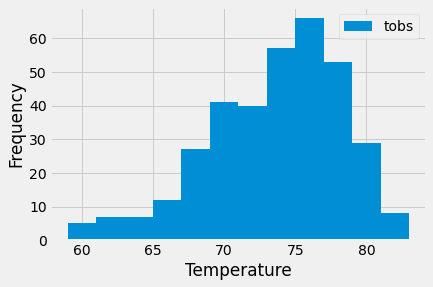

In [18]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# Finding most recent Waihee date
Waihee_Past_12_Months = engine.execute("SELECT Measurement.station, Measurement.tobs FROM Measurement \
                                        JOIN Station \
                                        ON Measurement.station = Station.station \
                                        WHERE Station.id = 7 \
                                        AND Measurement.date between '2016-08-23' AND '2017-08-23'; ").fetchall()

# Convert to Data Frame
WaiheeDF = pd.DataFrame(Waihee_Past_12_Months)

# plot histogram
WaiheeDF.plot(kind='hist',bins=12)
plt.xlabel('Temperature')
plt.show()

# Close session

In [19]:
# Close Session
session.close()